# Prudential Insurance

In [1]:
# import libraries
# General Utilities for Web Scraping
import re
import sys
import os
from os import listdir
from os.path import isfile, join, isdir
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import date, datetime
from dateutil import relativedelta
import csv
import json
import collections
from collections import defaultdict
from collections import Counter

# Read pdf modules
from tabula import wrapper
from pdfminer import pdfparser
from PyPDF2 import PdfFileReader
from io import BytesIO
import pdftables_api
pdftables_api_key = 'l8xmb9y624xz' # API Key to use pdftables_api

# Machine Learning Utitilies
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import seaborn as sns

# plotting defaults
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)
get_colors = lambda length: plt.get_cmap('Spectral')(np.linspace(0, 1.0, length))

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)

---
## Questions:

- How long is a policy year?
- None of these plans cover non-emergency overseas treatment right? Nope
- How long after signing can I make my first claim?
    - Almost immendiately when the policy is enforced
        - Accident & Emergency but no hospitalization have to manually claim
        - just tell her then manually claim 
- What’s the flexibility like in adding the supplementary plans and downgrading / upgrading my integrated shield plans?
    - Just simply downgrade through a form, but upgrading is very hard
- Is the Claims-based pricing only for the **PRU**extra Premier CoPay Supplementary Plan?
- When they say up to ${\$1,750}$ per policy year for PRUextra Premier Lite CoPay, they mean ${\$1,750}$ is the max they will pay per policy year?

---
## Premiums:

Restructured & Private:
- PRUshield Premier 
- Supplementary Plans
    1. PRUextra Premier CoPay
    2. PRUextra Premier Lite Copay

### Extract Data from Prudential Hospitalization Insurance policies

In [3]:
# # Links to the pdf for Prudential 
# # Integrated Shield & CoPay premiums
# prushield_premium_url = 'https://www.prudential.com.sg/-/media/prudential/pdf/ebrochures/prushieldpremiumstable_reprice.ashx?la=en&hash=120774C051686BA41B7C034B8B50130F33DCECE53EF72DCCA7BF52E256AF9BDF'
# pruextra_premium_url = 'https://www.prudential.com.sg/-/media/prudential/pdf/ebrochures/prushieldpremiumstable_copay.ashx?la=en&hash=E708BDE7B4AACDA28998E9E33C6741990EE31C034F130CC4DABCDCD8A83D8320' 

In [4]:
# # Save the online pdfs to pdfs 
# # on local machine
# prushield_premium_res = requests.get(prushield_premium_url)
# if prushield_premium_res.ok:
#     open('./data/prushield_premium.pdf', 'wb') \
#         .write(prushield_premium_res.content)
# else:
#     print('Failed to request {}'.format(prushield_premium_url))
    
# pruextra_premium_res = requests.get(pruextra_premium_url)
# if pruextra_premium_res.ok:
#     open('./data/pruextra_premium.pdf', 'wb') \
#         .write(pruextra_premium_res.content)
# else:
#     print('Failed to request {}'.format(pruextra_premium_url))

In [5]:
# Convert the .pdf to .csv using pdftables_api
# c = pdftables_api.Client(pdftables_api_key)
# c.csv('./data/prushield_premium.pdf', './data/prushield_premium.csv')
# c.csv('./data/pruextra_premium.pdf', './data/pruextra_premium.csv')

### PRUshield Premier Premiums

In [99]:
# Read in prushield_premium.csv
prushield_premium_df = pd.read_csv('./data/prushield_premium.csv', header=None)
prushield_premium_df.head()

,0,1,2,3,4
0,PRUshield Standard Plan Annual Premiums (S$),NaN,NaN,NaN,NaN
1,(Inclusive of 7% GST),NaN,NaN,NaN,NaN
2,For Singaporeans and Permanent Residents of Si...,NaN,NaN,NaN,NaN
3,Age Next,MediShield LifePremiums,NaN,Additional Private Insurance Coverage,NaN
4,Birthday,(fully payable by Medisave 2),Premiums,Additional Withdr3awal,Cash Outlay4


In [101]:
# Get the Prushield premier plans
# for Singaporeans
prushield_premier_start_idx = [idx for idx, val in enumerate(prushield_premium_df[0]) if 'premier' in str(val).lower()][0]
prushield_premier_end_idx = [idx for idx, val in enumerate(prushield_premium_df[0]) if '>' in str(val)][0] + 1
prushield_premier_df = prushield_premium_df \
    .iloc[prushield_premier_start_idx:prushield_premier_end_idx, :]
prushield_premier_df.tail()

,0,1,2,3,4
162,976,"1,530","9,759",900,"8,859"
163,986,"1,530","9,759",900,"8,859"
164,996,"1,530","9,759",900,"8,859"
165,1006,"1,530","9,759",900,"8,859"
166,> 1006,"1,530","9,759",900,"8,859"


Let's clean the prushield_premier dataframe

In [102]:
# Only keep the numerical rows for first column
prushield_premier_df = prushield_premier_df[
    prushield_premier_df[0] \
        .apply(lambda val: str(val).isnumeric() or '>' in str(val))
]

# Clean age next birthday to ensure age only goes up to 2 digits
prushield_premier_df[0] = prushield_premier_df[0] \
    .apply(lambda val: val[:-1] if len(val) > 2 else val)

# Set the column names
prushield_premier_df.columns = [
    'age_next_birthday',
    'medishieldlife_premiums',
    'prushield_premiums',
    'awls',
    'cash_outlay'
]

# Set the index to the age on next birthday
prushield_premier_df.index = prushield_premier_df['age_next_birthday'].astype(str)
prushield_premier_df = prushield_premier_df.drop('age_next_birthday', axis=1)
prushield_premier_df.tail()

,medishieldlife_premiums,prushield_premiums,awls,cash_outlay
age_next_birthday,,,,
97,"1,530","9,759",900,"8,859"
98,"1,530","9,759",900,"8,859"
99,"1,530","9,759",900,"8,859"
100,"1,530","9,759",900,"8,859"
> 100,"1,530","9,759",900,"8,859"


### PRUextra Premier Premiums

In [133]:
# Read in pruextra_premium.csv
pruextra_premium_df = pd.read_csv('./data/pruextra_premium.csv', header=None)
pruextra_premium_df.head()

,0,1,2,3,4
0,PRUExtra Premier CoPay (S$),NaN,NaN,NaN,NaN
1,(Inclusive of 7% GST),NaN,NaN,NaN,NaN
2,For Singapore Citizens / Singapore Permanent R...,NaN,NaN,NaN,NaN
3,who are dependants of Singapore Citizens or Si...,NaN,NaN,NaN,NaN
4,Age Next,Annual,NaN,Monthly1,NaN


In [134]:
# Get the Pruextra premier plans
# for Singaporeans
pruextra_premier_start_idx = [idx for idx, val in enumerate(pruextra_premium_df[0]) if 'premier' in str(val).lower()][0]
pruextra_premier_end_idx = [idx for idx, val in enumerate(pruextra_premium_df[0]) if '>' in str(val)][0] + 1
pruextra_premier_df = pruextra_premium_df \
    .iloc[pruextra_premier_start_idx:pruextra_premier_end_idx, :]
pruextra_premier_df.tail()

,0,1,2,3,4
108,"972,3",7721.60,9652,656.34,820.42
109,"982,3",7835.20,9794,665.99,832.49
110,"992,3",7946.40,9933,675.44,844.31
111,"1002,3",8059.20,10074,685.03,856.29
112,">1002,3",8059.20,10074,685.03,856.29


In [135]:
# Only keep the numerical rows for first column
pruextra_premier_df = pruextra_premier_df[
    pruextra_premier_df[0] \
        .apply(lambda val: str(val).isnumeric() or '>' in str(val) or ',' in str(val))
]

# Clean age next birthday to ensure age only goes up to 2 digits
pruextra_premier_df[0] = pruextra_premier_df[0] \
    .apply(lambda val: \
           val.replace(',', '')[:-2] if len(val.replace(',', '')) > 3 \
               else (val.replace(',', '')[:-1] if len(val.replace(',', '')) > 2 \
                   else val.replace(',', '') \
                  ) \
          )

# Set the column names
pruextra_premier_df.columns = [
    'age_next_birthday',
    'pruwell_reward_premiums_per_annum',
    'standard_level_premiums_per_annum',
    'pruwell_reward_premiums_per_month',
    'standard_level_premiums_per_month'
]

# Set the index to the age on next birthday
pruextra_premier_df.index = pruextra_premier_df['age_next_birthday'].astype(str)
pruextra_premier_df = pruextra_premier_df.drop('age_next_birthday', axis=1)
pruextra_premier_df.tail()

,pruwell_reward_premiums_per_annum,standard_level_premiums_per_annum,pruwell_reward_premiums_per_month,standard_level_premiums_per_month
age_next_birthday,,,,
97,7721.60,9652,656.34,820.42
98,7835.20,9794,665.99,832.49
99,7946.40,9933,675.44,844.31
100,8059.20,10074,685.03,856.29
>100,8059.20,10074,685.03,856.29


### PRUextra Premier Lite Premiums

In [197]:
# Get the Pruextra premier_lite plans
# for Singaporeans
pruextra_premier_lite_start_idx = [idx for idx, val in enumerate(pruextra_premium_df[0]) if 'lite' in str(val).lower()][0]
pruextra_premier_lite_end_idx = [idx for idx, val in enumerate(pruextra_premium_df[0][pruextra_premier_lite_start_idx:]) if '>' in str(val)][0] + pruextra_premier_lite_start_idx + 1
pruextra_premier_lite_df = pruextra_premium_df \
    .iloc[pruextra_premier_lite_start_idx:pruextra_premier_lite_end_idx, :]
pruextra_premier_lite_df.tail()

,0,1,2,3,4
328,973,"3,915",332.78,NaN,NaN
329,983,"3,962",336.77,NaN,NaN
330,993,"4,050",344.25,NaN,NaN
331,1003,"4,078",346.63,NaN,NaN
332,>1003,"4,078",346.63,NaN,NaN


In [198]:
# Drop last 2 columns
pruextra_premier_lite_df = pruextra_premier_lite_df.iloc[:, :-2]
pruextra_premier_lite_df[0] = pruextra_premier_lite_df[0].apply(lambda val: str(val).replace(' ', '').replace(',', ''))

# Only keep the numerical rows for first column
pruextra_premier_lite_df = pruextra_premier_lite_df[
    pruextra_premier_lite_df[0] \
        .apply(lambda val: str(val).isnumeric() or '>' in str(val))
]

# Clean age next birthday to ensure age only goes up to 2 digits
pruextra_premier_lite_df[0] = pruextra_premier_lite_df[0] \
    .apply(lambda val: \
           val[:-1] if len(val) > 2 \
           else val \
          )

# Set the column names
pruextra_premier_lite_df.columns = [
    'age_next_birthday',
    'premiums_per_annum',
    'premiums_per_month'
]

# Set the index to the age on next birthday
pruextra_premier_lite_df.index = pruextra_premier_lite_df['age_next_birthday'].astype(str)
pruextra_premier_lite_df = pruextra_premier_lite_df.drop('age_next_birthday', axis=1)
pruextra_premier_lite_df.tail()

,premiums_per_annum,premiums_per_month
age_next_birthday,,
97,"3,915",332.78
98,"3,962",336.77
99,"4,050",344.25
100,"4,078",346.63
>100,"4,078",346.63


### Visualizations

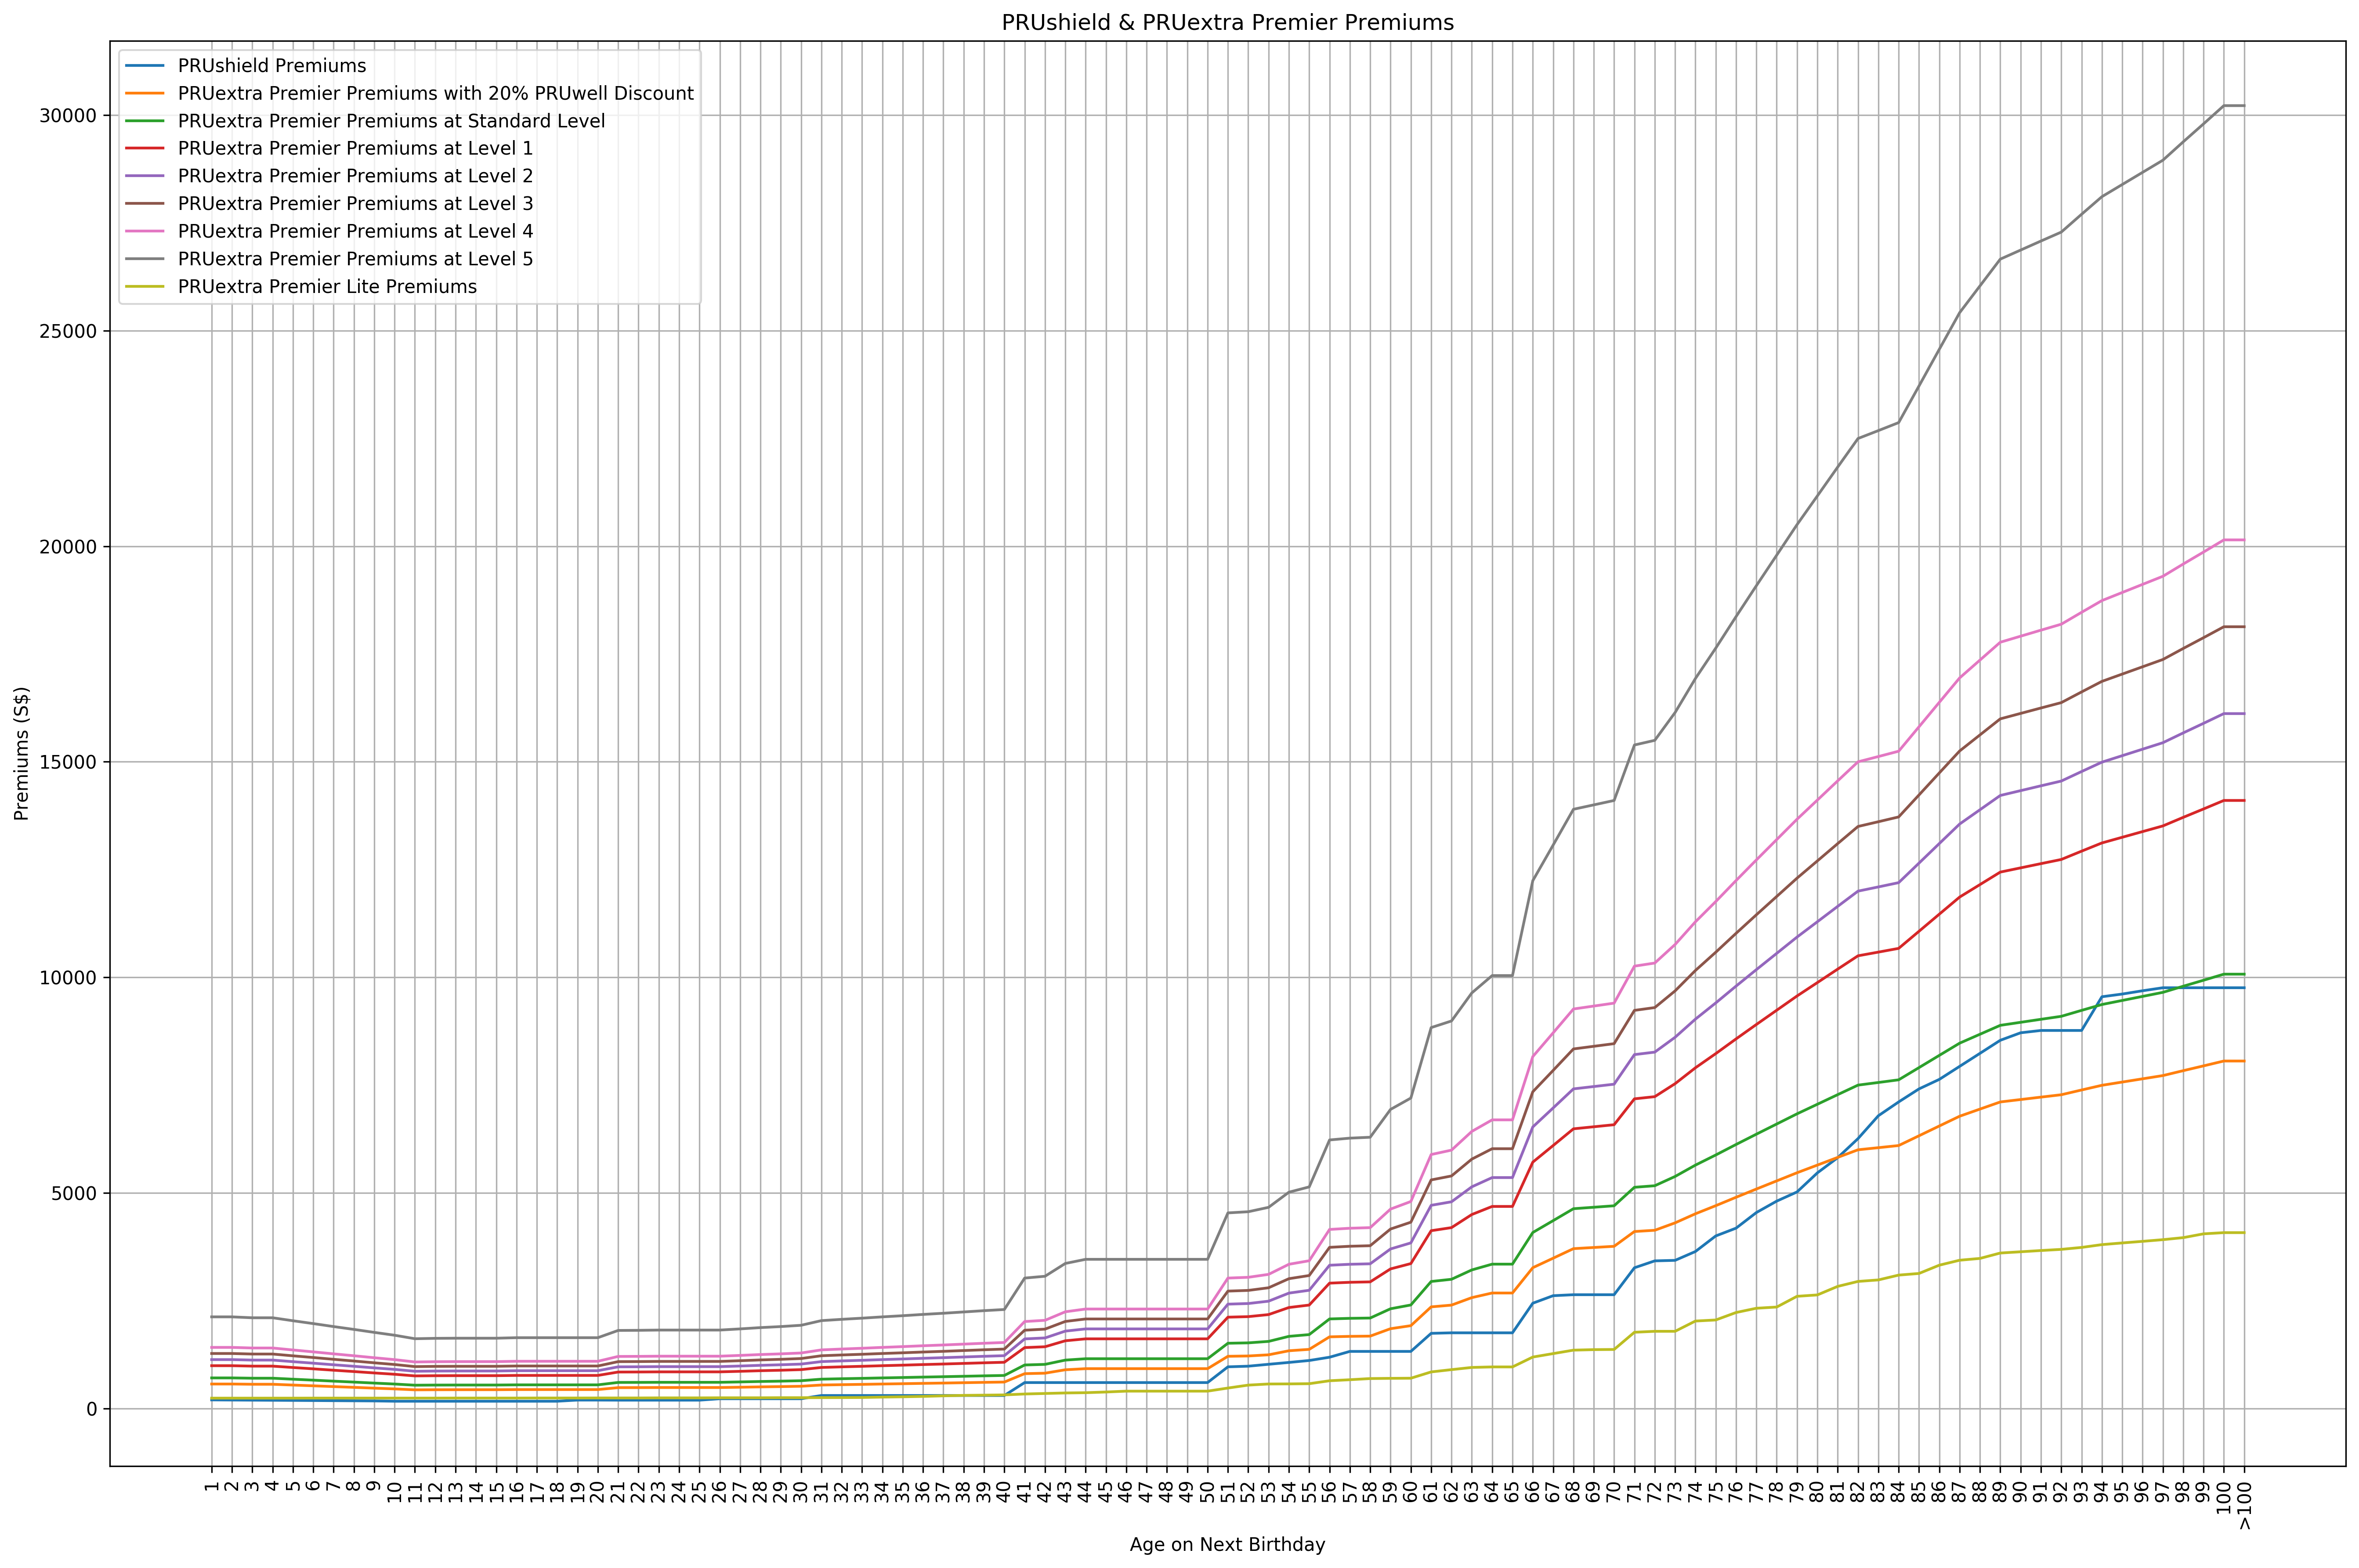

In [199]:
# Let's take a look
# at the pruextra premiums over time
fig, ax = plt.subplots(1, 1)
ax.plot(
    pruextra_premier_df.index,
    prushield_premier_df['prushield_premiums'] \
        .apply(lambda val: int(str(val).replace(',', ''))),
    label='PRUshield Premiums'
)
ax.plot(
    pruextra_premier_df.index,
    pruextra_premier_df['pruwell_reward_premiums_per_annum'] \
        .apply(lambda val: float(str(val).replace(',', ''))),
    label='PRUextra Premier Premiums with 20% PRUwell Discount'
)
ax.plot(
    pruextra_premier_df.index,
    pruextra_premier_df['standard_level_premiums_per_annum'] \
        .apply(lambda val: float(str(val).replace(',', ''))),
    label='PRUextra Premier Premiums at Standard Level'
)
ax.plot(
    pruextra_premier_df.index,
    pruextra_premier_df['standard_level_premiums_per_annum'] \
        .apply(lambda val: float(str(val).replace(',', '')) * 1.4),
    label='PRUextra Premier Premiums at Level 1'
)
ax.plot(
    pruextra_premier_df.index,
    pruextra_premier_df['standard_level_premiums_per_annum'] \
        .apply(lambda val: float(str(val).replace(',', '')) * 1.6),
    label='PRUextra Premier Premiums at Level 2'
)
ax.plot(
    pruextra_premier_df.index,
    pruextra_premier_df['standard_level_premiums_per_annum'] \
        .apply(lambda val: float(str(val).replace(',', '')) * 1.8),
    label='PRUextra Premier Premiums at Level 3'
)
ax.plot(
    pruextra_premier_df.index,
    pruextra_premier_df['standard_level_premiums_per_annum'] \
        .apply(lambda val: float(str(val).replace(',', '')) * 2),
    label='PRUextra Premier Premiums at Level 4'
)
ax.plot(
    pruextra_premier_df.index,
    pruextra_premier_df['standard_level_premiums_per_annum'] \
        .apply(lambda val: float(str(val).replace(',', '')) * 3),
    label='PRUextra Premier Premiums at Level 5'
)
ax.plot(
    pruextra_premier_df.index,
    pruextra_premier_lite_df['premiums_per_annum'] \
        .apply(lambda val: float(str(val).replace(',', ''))),
    label='PRUextra Premier Lite Premiums'
)
ax.grid()
ax.set_xlabel('Age on Next Birthday')
ax.set_xticklabels(pruextra_premier_df.index, rotation=90)
ax.set_ylabel('Premiums (S$)')
ax.set_title('PRUshield & PRUextra Premier Premiums')
ax.legend()
plt.tight_layout()
plt.show();

### Claims-based Pricing for PRUextra Premier Supplementary Plan

<img src='./img/claims_based_pricing_prushield_premier.png' />

In [141]:
prushield_premier_df.loc['23']

medishieldlife_premiums    195
prushield_premiums         192
awls                       300
cash_outlay                NaN
Name: 23, dtype: object

In [142]:
pruextra_premier_df.loc['23']

pruwell_reward_premiums_per_annum    484.80
standard_level_premiums_per_annum       606
pruwell_reward_premiums_per_month     41.21
standard_level_premiums_per_month     51.51
Name: 23, dtype: object

In [149]:
float(prushield_premier_df.loc['23']['medishieldlife_premiums']) \
+ float(prushield_premier_df.loc['23']['prushield_premiums']) \
+ float(pruextra_premier_df.loc['23']['pruwell_reward_premiums_per_annum'])

871.8

In [203]:
float(prushield_premier_df.loc['23']['medishieldlife_premiums']) \
+ float(prushield_premier_df.loc['23']['prushield_premiums']) \
+ float(pruextra_premier_df.loc['23']['standard_level_premiums_per_annum']) * 3

2205.0

<img src='./img/pruextra_premier_vs_lite.png' />

In [200]:
float(prushield_premier_df.loc['23']['medishieldlife_premiums']) \
+ float(prushield_premier_df.loc['23']['prushield_premiums']) \
+ float(pruextra_premier_lite_df.loc['23']['premiums_per_annum'])

632.0

monday, wednesday lunch

---
## Resources:
- [Prudential Hospitalization Insurance Brochure](https://www.prudential.com.sg/-/media/prudential/pdf/ebrochures/prushield_ebrochure_english.ashx)
- [PRUshield Premiums](https://www.prudential.com.sg/-/media/prudential/pdf/ebrochures/prushieldpremiumstable_reprice.ashx?la=en&hash=120774C051686BA41B7C034B8B50130F33DCECE53EF72DCCA7BF52E256AF9BDF)
- [PRUextra Premiums](https://www.prudential.com.sg/-/media/prudential/pdf/ebrochures/prushieldpremiumstable_copay.ashx?la=en&hash=E708BDE7B4AACDA28998E9E33C6741990EE31C034F130CC4DABCDCD8A83D8320)